# Performance Tests of Apache Spark-Based DC2 Run 1.1 Object Catalog Access
Author: **Julien Peloton [@JulienPeloton](https://github.com/JulienPeloton)**  
Last Run: **2018-10-17**  
See also: [issue/249](https://github.com/LSSTDESC/DC2-production/issues/249)

Introduce Apache Spark and test performance of data manipulations of the static coadd catalogs.


## Before starting...

**What is Apache Spark?**

I'm glad you asked! [Apache Spark](http://spark.apache.org/) is a cluster computing framework, that is a set of tools to perform computation on a network of many machines. Spark started in 2009 as a research project, and it had a huge success so far in the industry. It is based on the so-called MapReduce cluster computing paradigm, popularized by the Hadoop framework using implicit data parallelism and fault tolerance. 

**Where to find information on running Spark at NERSC?**

Most of what you need for interactive and batch jobs is at [spark-distributed-analytic-framework](https://www.nersc.gov/users/data-analytics/data-analytics-2/spark-distributed-analytic-framework/).

For JupyterLab use, see below.

**Where this Notebook is intended to be run?**

These tests were conducted on NERSC through the https://jupyter-dev.nersc.gov interface.

**What is needed to run this Notebook at NERSC?**

1. You need an account at NERSC, and access to the DESC allocation.

2. This Notebook requires a pyspark kernel. The easiest way to get one, 
is to generate one using the [spark-kernel-nersc](https://github.com/astrolabsoftware/spark-kernel-nersc) repository. 
The simplest kernel to play with this Notebook would be generated using:

```bash
# Clone the repo
git clone https://github.com/astrolabsoftware/spark-kernel-nersc.git
cd spark-kernel-nersc

# Where the Spark logs will be stored
# Logs can be then be browsed from the Spark UI
LOGDIR=${SCRATCH}/spark/event_logs
mkdir -p ${LOGDIR}

# Resource to use. Here we will use 4 CPUs.
RESOURCE=local[4]

# Extra libraries (comma separated if many) to use.
SPARKFITS=com.github.astrolabsoftware:spark-fits_2.11:0.7.0

# Create the kernel - will be stored under
# \$HOME/.ipython/kernels/<kernelname>
python makekernel.py \
  -kernelname pyspark_2.3.0 -spark_version 2.3.0 \ 
  -pyspark_args "--master ${RESOURCE} 
  --conf spark.eventLog.enabled=true 
  --conf spark.eventLog.dir=file://${LOGDIR} 
  --conf spark.history.fs.logDirectory=file://${LOGDIR} 
  --packages ${SPARKFITS}"
```

Finally log on https://jupyter-dev.nersc.gov, open this Notebook and choose the kernel you just created.
If you encounter problem with this kernel (I do have sometimes problems after NERSC updates), switch to another one. Two possibilities:

- Choose another shifter image containing Spark.
- Choose a Spark version not using Shifter: `python makekernel.py -kernelname pyspark_2.1.0 -spark_version 2.1.0 ...`

**Where is the data used in this Notebook?**

Data used can be found at 

```
/global/projecta/projectdirs/lsst/global/in2p3/Run1.1/summary/
```

Apache Spark can read a large number of data formats (Parquet, Avro, text) but officially neither FITS nor HDF5 are supported. We developed a solution for FITS files ([spark-fits](https://github.com/astrolabsoftware/spark-fits), Scala/Java/Python/R API), but as far as I know there is no Python-friendly connector for HDF5. Therefore we will focus only on Parquet and FITS in this Notebook.

**Note concerning resources**

```
The large-memory login node used by https://jupyter-dev.nersc.gov/
is a shared resource, so please be careful not to use too many CPUs
or too much memory.

That means avoid using `--master local[*]` in your kernel, but limit
the resources to a few core. Typically `--master local[4]` is enough for
prototyping a program.

Then to scale the analysis, the best is to switch to batch mode! 
Here, no limit!
```

## Loading the data

We will follow what is done on the Dask Notebook (put link).
We will first focus on one `patch` (4850) with all `tracts`.

### Disclaimer

Apache Spark, is meant to be primarily used in a context of _big data_.
One of its strength is its scalability, namely its capability of using the same
piece of code regardless the underlying data volume. The performance of the code will
then only depend on the resource used. 
E.g. for tasks without communications, execution time will be linear with data or resource.

Keep in mind:
- For small volume of data (< 10 GB), you will hit Spark noise and burning time.
- Spark is written in Scala, which is certainly not as specialised as C++ could be. Therefore for small volume of data, there is a chance an algorithm in Scala (Spark) would be slower than its C++ counterpart. But the Spark one is meant to run on TB of data _as it was written_ for MB of data - which is probably not the case for the C++.
- Once the data loaded, you can decide to keep it in memory (distributed among the executors). The next iterations will then go super fast (typically disk I/O throughput is o(100) MB/s while RAM is o(10) GB/s).

So in this example, the one patch test is likely to lessen Spark performance (volume is just few GB here), and these tests must also be ran on hundreds of GB of data.

In [1]:
import os

base_dir = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.1/summary'

# Load one patch, all tracts
datafile = os.path.join(base_dir, 'dpdd_object.parquet')
print("Data will be read from: \n", datafile)

Data will be read from: 
 /global/projecta/projectdirs/lsst/global/in2p3/Run1.1/summary/dpdd_object.parquet


## Loading data into a DataFrame

Let's initialise Spark and load the data into a DataFrame. We will first focus on the `parquet` data format.

In [2]:
from pyspark.sql import SparkSession

# Initialise our Spark session
spark = SparkSession.builder.getOrCreate()

# Read the data as DataFrame
df = spark.read.format("parquet").load(datafile)

# Check what we have in the file
df.printSchema()

root
 |-- magerr_i: double (nullable = true)
 |-- psFlux_i: double (nullable = true)
 |-- Ixx_r: double (nullable = true)
 |-- mag_i_cModel: double (nullable = true)
 |-- IxxPSF_u: double (nullable = true)
 |-- magerr_r: double (nullable = true)
 |-- psf_fwhm_i: double (nullable = true)
 |-- psf_fwhm_r: double (nullable = true)
 |-- Ixx: double (nullable = true)
 |-- magerr_g_cModel: double (nullable = true)
 |-- I_flag_y: boolean (nullable = true)
 |-- Iyy_z: double (nullable = true)
 |-- IxyPSF_i: double (nullable = true)
 |-- Ixx_z: double (nullable = true)
 |-- magerr_u_cModel: double (nullable = true)
 |-- IxyPSF: double (nullable = true)
 |-- snr_u_cModel: double (nullable = true)
 |-- IxxPSF_y: double (nullable = true)
 |-- psFlux_flag_i: boolean (nullable = true)
 |-- IyyPSF_g: double (nullable = true)
 |-- Ixy: double (nullable = true)
 |-- magerr_y: double (nullable = true)
 |-- psFlux_g: double (nullable = true)
 |-- snr_y_cModel: double (nullable = true)
 |-- Ixy_z: double 

In [3]:
# Get number of elements
print("One tract DataFrame has length:", df.count())
%timeit c = df.count()

One tract DataFrame has length: 6892380
961 ms ± 89.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Some statistics about the data

Let's play with the data. We will see how to compute statistics (mean, std, etc...) and ...

In [4]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col

def stat_one_col(df: DataFrame, colname: str) -> DataFrame:
    """ Return some statistics about one DataFrame Column.
    Statistics include: count, mean, stddev, min, max.
    
    Parameters
    ----------
    df : DataFrame
        Spark DataFrame
    colname : str
        Name of the Column for which we want the statistics
        
    Returns
    ----------
    out : DataFrame
        DataFrame containing statistics about the Column.
    """
    return df.select(colname).describe()

def stat_diff_col(df: DataFrame, colname_1: str, colname_2: str) -> DataFrame:
    """ Return some statistics about the difference of 
    two DataFrame Columns.
    Statistics include: count, mean, stddev, min, max.
    
    Parameters
    ----------
    df : DataFrame
        Spark DataFrame
    colname_1 : str
        Name of the first Column
    colname_2 : str
        Name of the second Column
        
    Returns
    ----------
    out : DataFrame
        DataFrame containing statistics about the Columns difference.
    """
    return df.select(col(colname_1) - col(colname_2)).describe()

In [5]:
# Get statistics about one column
stat_one_col(df, 'mag_g').show()
%timeit c = stat_one_col(df, 'mag_g').collect()

# Get statistics for the difference of two columns
stat_diff_col(df, 'mag_g', 'mag_r').show()
%timeit d = stat_diff_col(df, 'mag_g', 'mag_r').collect()

+-------+------------------+
|summary|             mag_g|
+-------+------------------+
|  count|           5698019|
|   mean|25.721391706804777|
| stddev|  2.16444185648169|
|    min|14.431595512576623|
|    max| 52.39393263760668|
+-------+------------------+

764 ms ± 31.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
+-------+------------------+
|summary|   (mag_g - mag_r)|
+-------+------------------+
|  count|           4172439|
|   mean|0.5274674368917402|
| stddev|1.6067276263035577|
|    min|-28.13517076318348|
|    max|33.316740496333026|
+-------+------------------+

The slowest run took 4.78 times longer than the fastest. This could mean that an intermediate result is being cached.
1.83 s ± 1.09 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


It takes roughly 1 second to produce statistics on the full dataset (6 million rows, 4.5 GB). This has to be compared to the 52 seconds for Dask to compute the `mean` using the same resource (4 CPU). Note that we didn't explicitly asked to put the data in cache (would be much faster). Note also that the number of elements for each column used to produce statistics varies (`count`). This is due to the fact that `NaN` are discarded.

I also ran this test with more resource (i.e. more CPUs), and the execution time gets smaller. Not linearly, as we hit Spark burning time (not enough data), but e.g. a few hundred of millisecond with 32 CPU.

## Reducing, playing, plotting

You can always go back to pandas world by using the `toPandas()` method. But be careful, if you do that on the full dataframe you will destroy your driver for sure! Spark DataFrames are abstractions of arbitrary amount of data. Invoking `toPandas()` triggers an action, and objects to transfer will be materialised. Imagine TB of data suddenly flowing to your driver...

So transfer only subset of the full Spark DataFrame to pandas. In pyspark there are several ways of selecting only subset of data: via SQL expression or DataFrame methods (which are somewhat related to each other...): 

In [6]:
# Subset of columns of interest
cols = "mag_g, mag_r, mag_i, magerr_g, magerr_r, magerr_i, extendedness"

# SQL - register first the DataFrame
df.createOrReplaceTempView("full_tract")

# Keeps only columns with 0.0 < magerr_g < 0.3
sql_command = """
    SELECT {}
    FROM full_tract 
    WHERE 
        magerr_g > 0 AND magerr_g < 0.3
""".format(cols)

# Execute the expression - return a DataFrame
df_sub = spark.sql(sql_command)
print("Number of elements selected: ", df_sub.count())
df_sub.show()

# Note that we could have done otherwise:
# Example with select.where
df.select(cols.split(", ")).where("magerr_g > 0 AND magerr_g < 0.3")
# Example with select.filter
df.select(cols.split(", ")).filter("magerr_g > 0 AND magerr_g < 0.3")

Number of elements selected:  3105
+------------------+-----+-----+--------------------+--------+--------+------------+
|             mag_g|mag_r|mag_i|            magerr_g|magerr_r|magerr_i|extendedness|
+------------------+-----+-----+--------------------+--------+--------+------------+
|24.429113805033165| null| null| 0.17433681481976254|    null|    null|         1.0|
|22.024261324698585| null| null| 0.02161721387034351|    null|    null|         1.0|
| 24.69324400740963| null| null| 0.22305382062532272|    null|    null|         0.0|
| 21.68204596875437| null| null|0.016841725270571026|    null|    null|         1.0|
|24.403918127051437| null| null| 0.17112604766847697|    null|    null|         0.0|
|24.457580040244093| null| null|   0.179198462359786|    null|    null|         0.0|
| 24.72899074947989| null| null| 0.22589982922168664|    null|    null|         0.0|
|24.990358570506444| null| null| 0.29540873684830055|    null|    null|         0.0|
|22.895663357632433| null| nul

DataFrame[mag_g: double, mag_r: double, mag_i: double, magerr_g: double, magerr_r: double, magerr_i: double, extendedness: double]

3000 objects, 7 columns - that's more reasonnable than the million ones! We can go to Pandas and play with our favourite plotting library such as seaborn:

In [7]:
df_pandas = df_sub.toPandas()

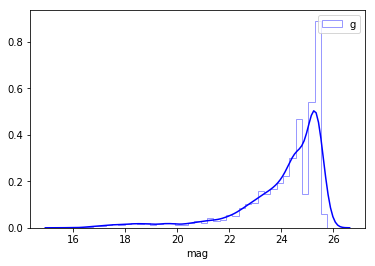

In [9]:
import seaborn as sns
import matplotlib.pyplot as pl

sns.distplot(df_pandas['mag_g'], label='g', color='blue', hist_kws={'histtype': 'step'})
pl.xlabel('mag')
pl.legend();

Following BigQuery notebook by wmwv, let's plot stars vs. galaxies:

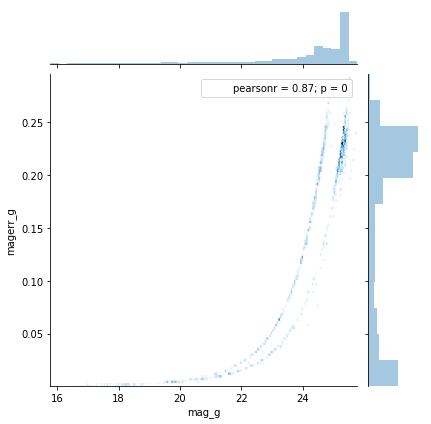

In [12]:
star = df_pandas[df_pandas['extendedness'] < 0.95]
gal = df_pandas[df_pandas['extendedness'] > 0.95]
sns.jointplot(
    star['mag_g'], star['magerr_g'], 
    label='"Stars"', kind='hexbin',
    gridsize=200);

## Data quality

**88% valid entries, 12% NaN**

In [13]:
from pyspark.sql.functions import col,sum

# Show the number of valid entries
entries = df.select(*(sum(col(c).isNotNull().cast("int")).alias(c) for c in df.columns)).collect()

In [16]:
import numpy as np

ini_len = df.count()
print("Input number of entries: {}".format(ini_len))
print("Total yield: {}%".format(np.sum(entries) / (ini_len * len(df.columns)) * 100))
for col, entry in zip(df.columns, entries[0]):
    print("{}: {} ({:.1f}%)".format(col, entry, entry/ini_len*100))

Input number of entries: 6892380
Total yield: 87.42589520552244%
magerr_i: 5272546 (76.5%)
psFlux_i: 6142802 (89.1%)
Ixx_r: 4997285 (72.5%)
mag_i_cModel: 5196764 (75.4%)
IxxPSF_u: 6791749 (98.5%)
magerr_r: 4819340 (69.9%)
psf_fwhm_i: 6295438 (91.3%)
psf_fwhm_r: 5781874 (83.9%)
Ixx: 4252164 (61.7%)
magerr_g_cModel: 6568933 (95.3%)
I_flag_y: 6892380 (100.0%)
Iyy_z: 5209439 (75.6%)
IxyPSF_i: 6295438 (91.3%)
Ixx_z: 5209439 (75.6%)
magerr_u_cModel: 6510048 (94.5%)
IxyPSF: 6892038 (100.0%)
snr_u_cModel: 6510048 (94.5%)
IxxPSF_y: 6342770 (92.0%)
psFlux_flag_i: 6892380 (100.0%)
IyyPSF_g: 6776910 (98.3%)
Ixy: 4252164 (61.7%)
magerr_y: 5040748 (73.1%)
psFlux_g: 6740025 (97.8%)
snr_y_cModel: 6045334 (87.7%)
Ixy_z: 5209439 (75.6%)
psFlux_flag_r: 6892380 (100.0%)
Iyy_g: 5556470 (80.6%)
psFluxErr_r: 5600369 (81.3%)
Ixx_i: 5306107 (77.0%)
snr_z_cModel: 5804192 (84.2%)
psf_fwhm_g: 6776910 (98.3%)
Ixx_y: 5036312 (73.1%)
I_flag: 6892380 (100.0%)
magerr_z: 5113937 (74.2%)
I_flag_i: 6892380 (100.0%)
IyyPS

## Future

- FITS?
- More data?
- More action?

## Garbage collection

In [58]:
# base_dir = 'file:///global/cscratch1/sd/peloton/dpdd/new_fits/*.fits'
# df = spark.read.format("fits").option("hdu", 1).load(base_dir)
# print(df.rdd.getNumPartitions())
# # df.count()

In [59]:
# df = df.coalesce(20).cache()
# print(df.count())
# %timeit df.count()

In [60]:
# fn = "file:///global/cscratch1/sd/peloton/LSST10Y_striped_small/out_srcs_s1_0.fits"
# df2 = spark.read.format("fits").option("hdu", 1).load(fn)
# print(df2.count())

In [61]:
# %timeit df2.count()

In [17]:
# from pyspark.sql.functions import col,sum
# df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()
# import glob
# base_dir = 'file:///global/cscratch1/sd/peloton/dpdd/new_fits/dpdd_object_tract_4639_patch_*.fits'
# df = spark.read.format("fits").option("hdu", 1).load(base_dir)
# df.count()
# for file in base_dir:
#     df = spark.read.format("fits").option("hdu", 1).load(file)
#     print(file, df.count())
# import warnings
# warnings.filterwarnings(action='once')

# Put the data in cache for the following
# df_cached = df.cache()

# # Trigger an action, to actually put data in cache
# # (Spark is lazy, and cache is a transformation!)
# with warnings.catch_warnings():
#     warnings.filterwarnings(action='once')
#     df_cached.count()